# ResNet50 Work - image augmentation

### Importing Libraires

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from tensorflow.keras.applications import ResNet50 # type: ignore
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout # type: ignore
from tensorflow.keras.models import Model # type: ignore
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint # type: ignore
from sklearn.metrics import classification_report, confusion_matrix

### Read the Data

In [2]:
# Import the utility functions
from animal_classification import get_data_generators, display_translated_labels

# Set the directory path for images
directory = r'../csv/raw-img'

# Get the data generators
train_generator, validation_generator = get_data_generators(directory)

# Display and translate class labels
class_labels, translated_labels = display_translated_labels(train_generator)


Found 22257 images belonging to 10 classes.
Found 3922 images belonging to 10 classes.
Original Class Labels: ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']
Translated Class Labels: ['dog', 'horse', 'elephant', 'butterfly', 'chicken', 'cat', 'cow', 'sheep', 'ragno', 'squirrel']


### Building of Resnet Model

In [3]:
# Load ResNet50 (as ResNet18 isn't directly in Keras Applications)
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base model's layers

In [4]:
for layer in base_model.layers[-10:]:
    layer.trainable = True

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Replace Flatten with Global Pooling
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)  # Add Dropout for regularization
outputs = Dense(10, activation='softmax')(x)  # Assuming 5-class classification

# Create the model
model = Model(inputs=base_model.input, outputs=outputs)

In [5]:
# Compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=["accuracy", "Precision", "Recall"]
)

In [6]:
# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6),
    # ModelCheckpoint('resnet50.keras', save_best_only=True) - had to comment out due to space
]

In [7]:
# Training
history = model.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=5,
                    callbacks=callbacks)

Epoch 1/5
696/696 [==============================] - 1523s 2s/step - loss: 2.0635 - accuracy: 0.2813 - precision: 0.5360 - recall: 0.0385 - val_loss: 3.0086 - val_accuracy: 0.2017 - val_precision: 0.2259 - val_recall: 0.1920 - lr: 0.0010
Epoch 2/5
696/696 [==============================] - 1695s 2s/step - loss: 1.8934 - accuracy: 0.3444 - precision: 0.5942 - recall: 0.0841 - val_loss: 2.8778 - val_accuracy: 0.2871 - val_precision: 0.3397 - val_recall: 0.2310 - lr: 0.0010
Epoch 3/5
696/696 [==============================] - 1934s 3s/step - loss: 1.8365 - accuracy: 0.3614 - precision: 0.6127 - recall: 0.1039 - val_loss: 3.3308 - val_accuracy: 0.2330 - val_precision: 0.2343 - val_recall: 0.2139 - lr: 0.0010
Epoch 4/5
696/696 [==============================] - 1585s 2s/step - loss: 1.7957 - accuracy: 0.3777 - precision: 0.6385 - recall: 0.1207 - val_loss: 2.1484 - val_accuracy: 0.2820 - val_precision: 0.4487 - val_recall: 0.1527 - lr: 0.0010
Epoch 5/5
696/696 [=============================

In [8]:
def plot_training_history(history, metrics, title="Training and Validation Metrics", save_path=None):
    valid_metrics = [metric for metric in metrics if metric in history.history]
    num_metrics = len(valid_metrics)
    rows = (num_metrics + 1) // 2
    fig, axs = plt.subplots(rows, 2, figsize=(14, 5 * rows))
    axs = axs.flatten()

    fig.suptitle(title, fontsize=16)

    for ax, metric in zip(axs, valid_metrics):
        ax.plot(history.history[metric], label=f'Training {metric.capitalize()}', color='blue', linestyle='-', marker='o')
        ax.plot(history.history[f'val_{metric}'], label=f'Validation {metric.capitalize()}', color='orange', linestyle='--', marker='x')
        ax.set_xlabel('Epochs')
        ax.set_ylabel(metric.capitalize())
        ax.set_title(f'Training vs. Validation {metric.capitalize()}')
        ax.legend()
        ax.grid(True)
        ax.set_ylim(0, 1)

    for i in range(num_metrics, len(axs)):
        fig.delaxes(axs[i])

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    
    if save_path:
        plt.savefig(save_path)
    
    plt.show()

metrics = ['accuracy', 'loss', 'recall', 'precision']

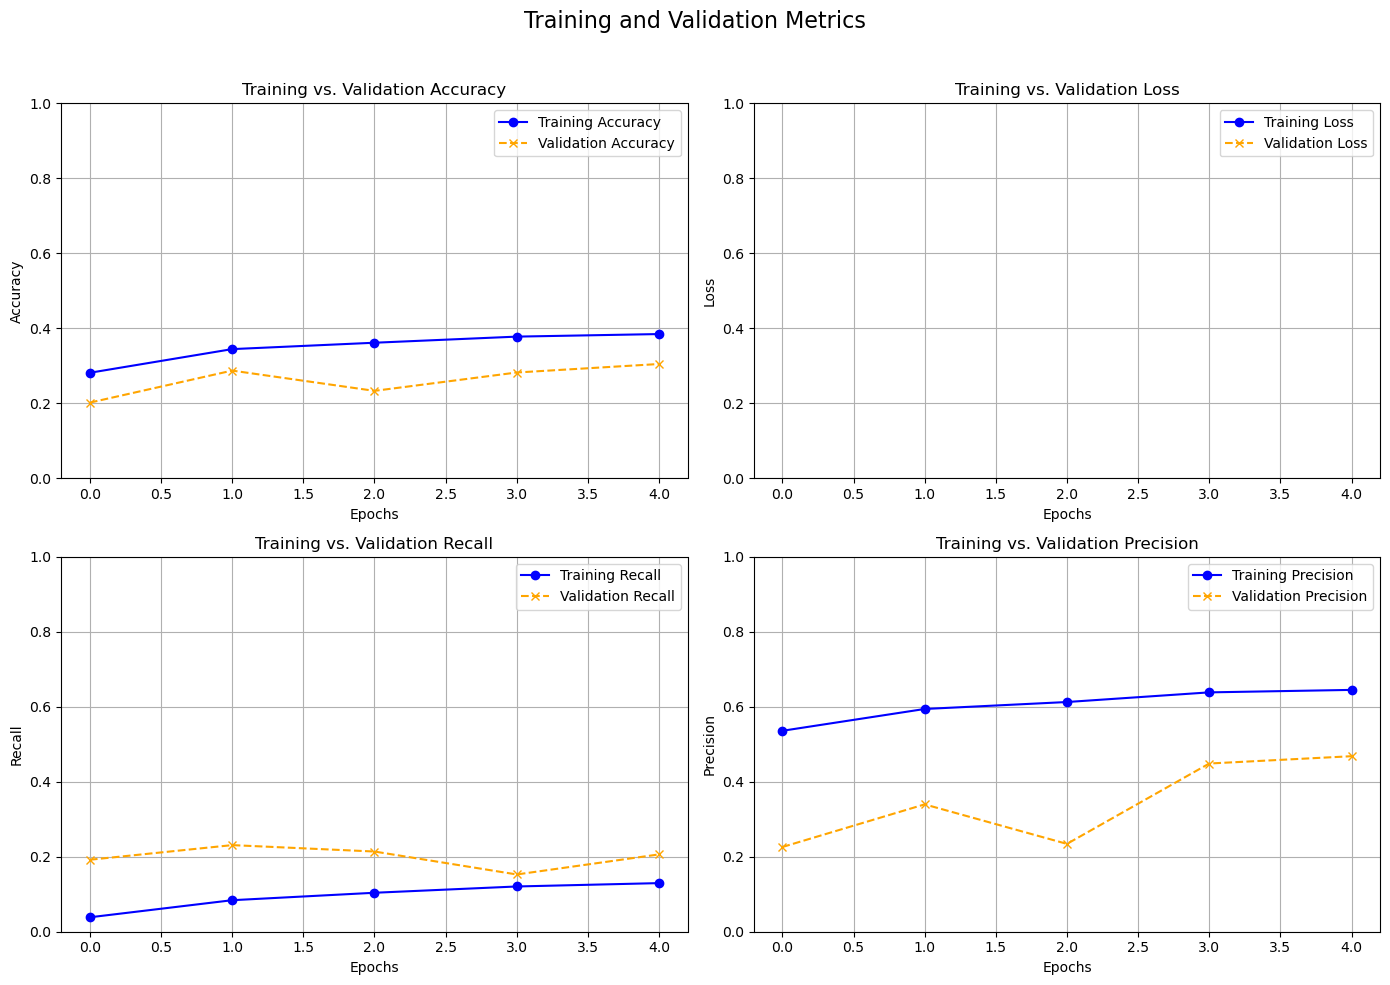

In [9]:
plot_training_history(history, metrics)

### Test Model

In [10]:
y_test = validation_generator.classes
y_pred = np.argmax(model.predict(validation_generator), axis=1)
print(classification_report(y_test, y_pred, target_names=translated_labels, zero_division=0))

123/123 [==============================] - 160s 1s/step
              precision    recall  f1-score   support

         dog       0.33      0.49      0.39       729
       horse       0.00      0.00      0.00       393
    elephant       0.00      0.00      0.00       216
   butterfly       0.24      0.80      0.37       316
     chicken       0.39      0.04      0.07       464
         cat       0.00      0.00      0.00       250
         cow       0.00      0.00      0.00       279
       sheep       0.00      0.00      0.00       273
       ragno       0.36      0.73      0.49       723
    squirrel       0.15      0.16      0.15       279

    accuracy                           0.31      3922
   macro avg       0.15      0.22      0.15      3922
weighted avg       0.20      0.31      0.21      3922



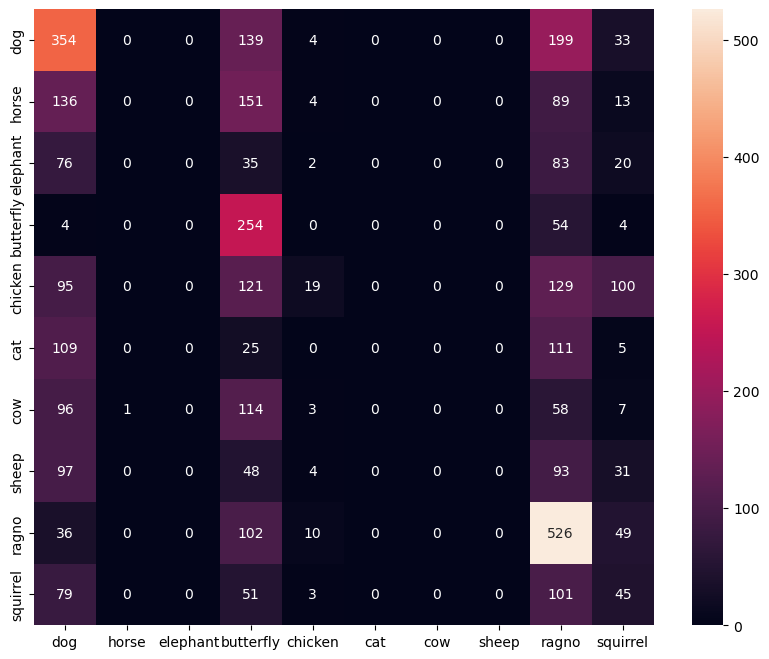

In [11]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=translated_labels, yticklabels=translated_labels)
plt.show()